# Introduction

The National Longitudinal Survey of Youth 1997-2011 dataset is one of the most important databases available to social scientists working with US data. 

It allows scientists to look at the determinants of earnings as well as educational attainment and has incredible relevance for government policy. It can also shed light on politically sensitive issues like how different educational attainment and salaries are for people of different ethnicity, sex, and other factors. When we have a better understanding how these variables affect education and earnings we can also formulate more suitable government policies. 

<center><img src=https://i.imgur.com/cxBpQ3I.png height=400></center>


### Upgrade Plotly

In [ ]:
%pip install --upgrade plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###  Import Statements


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Notebook Presentation

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

# Load the Data



In [ ]:
df_data = pd.read_csv('NLSY97_subset.csv')

### Understand the Dataset

Have a look at the file entitled `NLSY97_Variable_Names_and_Descriptions.csv`. 

---------------------------

    :Key Variables:  
      1. S           Years of schooling (highest grade completed as of 2011)
      2. EXP         Total out-of-school work experience (years) as of the 2011 interview.
      3. EARNINGS    Current hourly earnings in $ reported at the 2011 interview

# Preliminary Data Exploration 🔎

**Challenge**

* What is the shape of `df_data`? 
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [ ]:
df_data.shape
df_data.columns
df_data.isna().values.any()
df_data.duplicated().values.any()

True

## Data Cleaning - Check for Missing Values and Duplicates

Find and remove any duplicate rows.

In [ ]:
df_data.drop_duplicates(inplace = True)
df_data.dropna(inplace = True)

## Descriptive Statistics

In [ ]:
df_data.describe()

,ID,EARNINGS,S,EXP,FEMALE,MALE,BYEAR,AGE,AGEMBTH,HHINC97,...,URBAN,REGNE,REGNC,REGW,REGS,MSA11NO,MSA11NCC,MSA11CC,MSA11NK,MSA11NIC
count,492.00,492.00,492.00,492.00,492.00,492.00,492.00,492.00,492.00,492.00,...,492.00,492.00,492.00,492.00,492.00,492.00,492.00,492.00,492.00,492.00
mean,"3,530.57",19.13,14.89,5.92,0.49,0.51,"1,982.98",28.02,26.74,"66,732.78",...,0.75,0.13,0.31,0.35,0.21,0.05,0.54,0.41,0.00,0.00
std,"1,948.08",11.54,2.69,2.51,0.50,0.50,0.82,0.82,4.71,"44,951.87",...,0.44,0.33,0.46,0.48,0.41,0.22,0.50,0.49,0.05,0.00
min,28.00,2.13,8.00,0.00,0.00,0.00,"1,982.00",27.00,17.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"1,833.25",12.00,12.00,4.24,0.00,0.00,"1,982.00",27.00,24.00,"40,725.00",...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"3,470.50",16.00,16.00,5.75,0.00,1.00,"1,983.00",28.00,26.00,"58,027.50",...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
75%,"5,186.75",24.04,17.00,7.75,1.00,1.00,"1,984.00",29.00,30.00,"77,432.50",...,1.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
max,"8,978.00",123.08,20.00,12.33,1.00,1.00,"1,984.00",29.00,41.00,"246,474.00",...,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00


In [ ]:
key_variables = ["S", "EXP", "EARNINGS"]

## Visualise the Features

Income distribution by gender

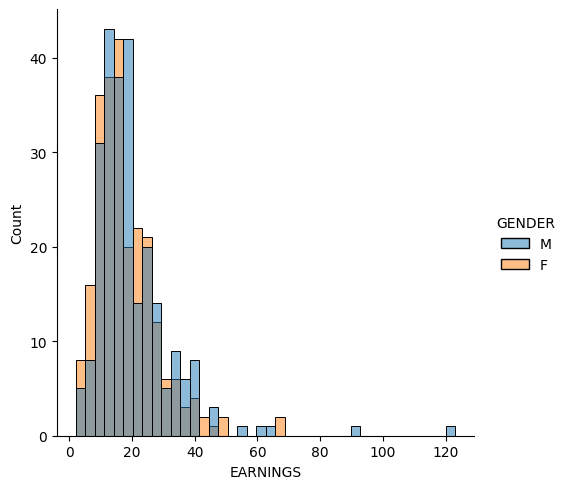

In [ ]:
df_data["GENDER"] = np.where(df_data.FEMALE == 1 , "F", "M")
sns.displot(df_data, x= "EARNINGS", hue="GENDER", stat="count")

Household type that each individual is from vs. highest education received

In [ ]:
#subset and pivot_longer the data to allow household type vs. education comparison.
household_types = [col for col in df_data if col.startswith('HH')]
household_types.insert(0,"ID")
education_status = [col for col in df_data if col.startswith('EDU')]
education_status.insert(0,"ID")

household_data = df_data[household_types]
pivoted_hh_data = pd.melt(household_data, id_vars = "ID").query("value == 1")

edu_data = df_data[education_status]
pivoted_edu_data = pd.melt(edu_data, id_vars = "ID").query("value == 1")


#relabel the coded variable with descriptive names
descriptive_names = pd.read_csv("NLSY97_Variable_Names_and_Descriptions.csv").rename(columns={"Personal variables": "variable"})
hh_summary = pd.merge(pivoted_hh_data,descriptive_names, how = "left", on =  "variable")[["ID","Description"]]
edu_summary = pd.merge(pivoted_edu_data,descriptive_names, how = "left", on =  "variable")[["ID","Description"]]
#after labeling education and household datasets separately, join on the unique ID
hh_edu_compare = pd.merge(hh_summary, edu_summary, how = "inner", on = "ID")
hh_edu_compare.columns = ["ID", "household_type", "highest_education"]
hh_edu_compare= hh_edu_compare.reset_index()
#perform aggregation to calculate the counts by household + education groups
hh_edu_stats = hh_edu_compare.groupby(["household_type", "highest_education"], as_index= False).agg({'ID': pd.Series.count}).rename(columns={"ID": "counts"})

In [ ]:
fig = px.pie(hh_edu_stats, labels="highest_education", values="counts", color="highest_education",
             facet_col="household_type", facet_col_wrap=1, names = "highest_education",
             title='highest level of education by house hold type')


fig.update_traces(textposition='inside', textinfo='percent')
 
fig.show()

# Split Training & Test Dataset

We *can't* use all the entries in our dataset to train our model. Keep 20% of the data for later as a testing dataset (out-of-sample data).  

In [ ]:
numeric_df = df_data.select_dtypes(include=[np.number])
target = numeric_df["EARNINGS"]
features = numeric_df.drop(["ID","EARNINGS"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state = 10)

In [ ]:
# % of training set
train_pct = 100*len(X_train)/len(features)
print(f'Training data is {train_pct:.3}% of the total data.')

# % of test data set
test_pct = 100*X_test.shape[0]/features.shape[0]
print(f'Test data makes up the remaining {test_pct:0.3}%.')

Training data is 79.9% of the total data.
Test data makes up the remaining 20.1%.


# Simple Linear Regression

Only use the years of schooling to predict earnings. Use sklearn to run the regression on the training dataset. How high is the r-squared for the regression on the training data? 

In [ ]:
#create a df containing S variable only
yrs_school = pd.DataFrame(X_train["S"], columns = ["S"])
regr = LinearRegression()
regr.fit(yrs_school, y_train)
rsquared = regr.score(yrs_school, y_train)

print(f'Training data r-squared: {rsquared:.2}')

Training data r-squared: 0.053


### Evaluate the Coefficients of the Model

Here we do a sense check on our regression coefficients. The first thing to look for is if the coefficients have the expected sign (positive or negative). 

Interpret the regression. How many extra dollars can one expect to earn for an additional year of schooling?

In [ ]:
print(f'Training data coeff of the model: {regr.coef_[0]:.2}')

Training data coeff of the model: 0.97


### Analyse the Estimated Values & Regression Residuals

How good our regression is also depends on the residuals - the difference between the model's predictions ( 𝑦̂ 𝑖 ) and the true values ( 𝑦𝑖 ) inside y_train. Do you see any patterns in the distribution of the residuals?

In [ ]:
predicted_values = regr.predict(yrs_school)
residuals = (y_train - predicted_values)

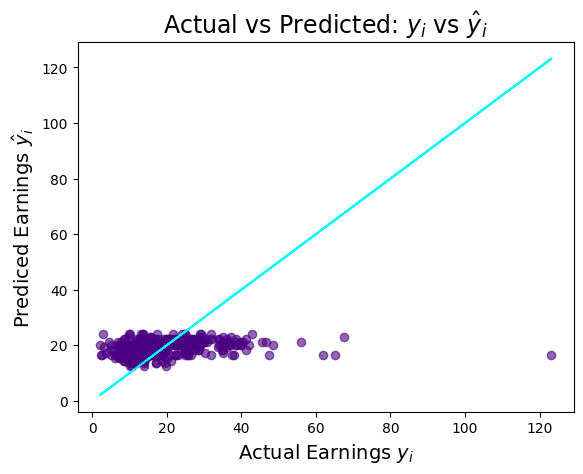

In [ ]:
# Original Regression of Actual vs. Predicted Earnings
plt.figure(dpi=100)
plt.scatter(x=y_train, y=predicted_values, c='indigo', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')
plt.title(f'Actual vs Predicted: $y _i$ vs $\hat y_i$', fontsize=17)
plt.xlabel('Actual Earnings $y _i$', fontsize=14)
plt.ylabel('Prediced Earnings $\hat y _i$', fontsize=14)
plt.show()


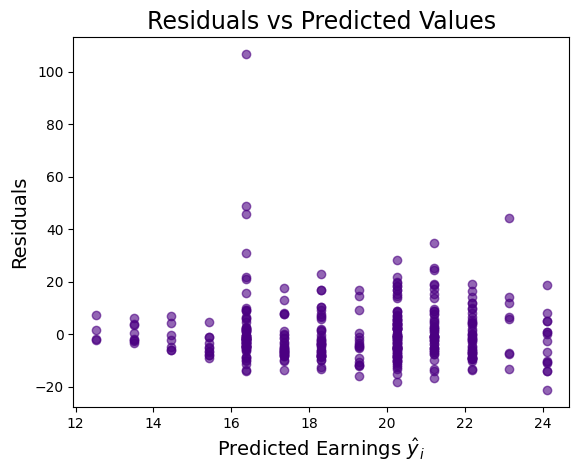

In [ ]:
# Residuals vs Predicted values
plt.figure(dpi=100)
plt.scatter(x=predicted_values, y=residuals, c='indigo', alpha=0.6)
plt.title('Residuals vs Predicted Values', fontsize=17)
plt.xlabel('Predicted Earnings $\hat y _i$', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

# Multivariable Regression

Now use both years of schooling and the years work experience to predict earnings. How high is the r-squared for the regression on the training data? 

In [ ]:
#create a df containing both years of schooling and the years work experience
ind_var = pd.DataFrame(X_train[["S","EXP"]], columns = ["S","EXP"])
m_regr = LinearRegression()
m_regr.fit(ind_var, y_train)
rsquared = m_regr.score(ind_var, y_train)

print(f'Training data r-squared: {rsquared:.2}')


Training data r-squared: 0.076


### Evaluate the Coefficients of the Model

In [ ]:
m_regr.coef_[0]

1.5534280292713094

### Analyse the Estimated Values & Regression Residuals

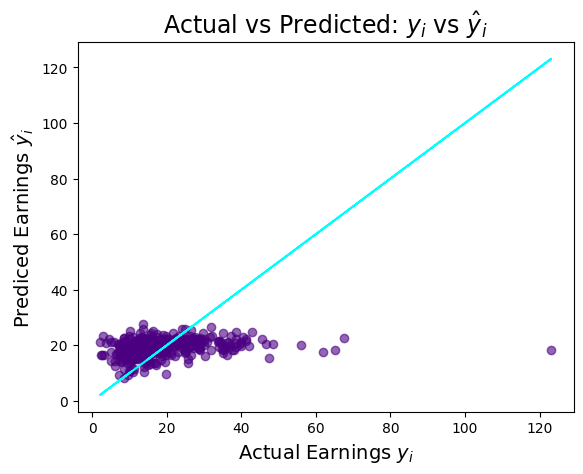

In [ ]:
predicted_values = m_regr.predict(ind_var)
residuals = (y_train - predicted_values)
# Original Regression of Actual vs. Predicted Earnings
plt.figure(dpi=100)
plt.scatter(x=y_train, y=predicted_values, c='indigo', alpha=0.6)
plt.plot(y_train, y_train, color='cyan')
plt.title(f'Actual vs Predicted: $y _i$ vs $\hat y_i$', fontsize=17)
plt.xlabel('Actual Earnings $y _i$', fontsize=14)
plt.ylabel('Prediced Earnings $\hat y _i$', fontsize=14)
plt.show()


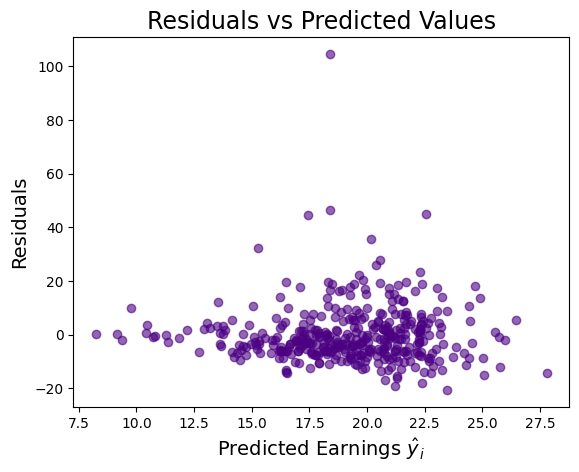

In [ ]:
# Residuals vs Predicted values
plt.figure(dpi=100)
plt.scatter(x=predicted_values, y=residuals, c='indigo', alpha=0.6)
plt.title('Residuals vs Predicted Values', fontsize=17)
plt.xlabel('Predicted Earnings $\hat y _i$', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.show()

# Use Your Model to Make a Prediction

How much can someone with a bachelors degree (12 + 4) years of schooling and 5 years work experience expect to earn in 2011?

In [ ]:
sample = pd.DataFrame({"S":[16], "EXP":[5]})
s_prediction = m_regr.predict(sample)
s_prediction = round(s_prediction[0],2)

In [ ]:
print(f" ${s_prediction} is the hourly earnings that someone with a bachelors degree (12 + 4) years of schooling and 5 years work experience expect to earn in 2011")

 $20.01 is the hourly earnings that someone with a bachelors degree (12 + 4) years of schooling and 5 years work experience expect to earn in 2011
